# Test technique Data Scientist — Ubisoft

Ce notebook présente le travail réalisé dans le cadre d’un test technique pour le poste de Scientifique des données - Canada Analytics Team chez Ubisoft.  

L’objectif de ce projet est d’explorer, analyser et exploiter les données fournies afin de répondre aux questions définies dans l’énoncé.  
L’approche suivie est volontairement structurée et reproductible, et couvre les principales étapes d’un projet data : compréhension des données, nettoyage, analyse exploratoire, modélisation et interprétation des résultats.  

> This notebook presents the work carried out as part of a technical test for a Data Scientist position at Ubisoft.
>
> The objective of this project is to explore, analyze and leverage the provided dataset in order to answer the questions described in the exercise statement.  
> The analysis follows a structured and reproducible data science workflow, including data exploration, cleaning, exploratory analysis, modeling, and interpretation of results.
>
> 


### Question 1
– Expliquez brièvement (maximum 2 lignes par colonne) votre compréhension du contenu de chaque colonne.
> – Briefly explain (max 2 lines per column) your understanding of what each column contains.

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)

In [87]:
df = pd.read_csv("data/technical_test_data(in).csv")
print(len(df))
df.head()

58510


,sessionid,playerid,serverdate_first,serverdate_last,clientdate_first,clientdate_last,dateid,countrycode,gameversion,playersessions_index,playdays_index,sessionuptime_duration,cum_playtime_duration,session_playtime_duration,population
0,-681224192,1497703947,6/6/2024 1:05,6/6/2024 1:32,6/6/2024 1:04,6/6/2024 1:32,20240606,BR,Full,1,1,1660,1287,1287,pop2
1,439644068,-582178240,6/6/2024 2:42,6/6/2024 2:42,6/6/2024 2:41,6/6/2024 2:41,20240606,DE,Full,9678,1,6,0,0,pop1
2,586332046,-582178240,6/6/2024 0:03,6/6/2024 0:03,6/6/2024 0:03,6/6/2024 0:03,20240606,DE,Full,9655,1,6,0,0,pop1
3,-78988545,228829462,6/6/2024 0:02,6/6/2024 3:57,6/6/2024 0:02,6/6/2024 3:57,20240606,ZA,Full,13,3,14100,0,0,pop1
4,69020027,-582178240,6/6/2024 23:59,6/6/2024 23:59,6/6/2024 23:59,6/6/2024 23:59,20240606,DE,Full,9744,1,7,0,0,pop1


**sessionid**  
Identifiant unique d’une session (persistante), qui peut correspondre a un client ouvert, un monde ou un compte connecté
> A unique identifier for a (persistent) session, which can correspond to an open client, a world, or a connected account.

**playerid**  
Identifiant unique du joueur, permettant de suivre son activité dans différentes sessions
> A unique identifier for the player, allowing their activity to be tracked across different sessions.

**serverdate_first**  
Date et heure côté serveur correspondant au début de l’activité observée pour cette session et ce joueur
> Server-side date and time corresponding to the start of the observed activity for this session and this player

**serverdate_last**  
Date et heure côté serveur correspondant à la fin de l’activité observée pour cette session et ce joueur
> Server-side date and time corresponding to the end of the observed activity for this session and this player

**clientdate_first**  
Date et heure côté client correspondant au début de l’activité du joueur dans la session
> Client-side date and time corresponding to the start of the player's activity in the session

**clientdate_last**  
Date et heure côté client correspondant à la fin de l’activité du joueur dans la session
> Client-side date and time corresponding to the end of the player's activity in the session

**dateid**  
Date de la session
> Session date

**countrycode**  
Code pays du joueur.
> Country code of the player

**gameversion**  
Version du jeu utilisée par le joueur, pouvant servir à distinguer différentes versions ou groupes de test
> The version of the game used by the player, which can be used to distinguish between different versions or test groups.

**playersessions_index**  
Identifiant du joueur pour la session observée
> Player ID for the observed session

**playdays_index**  
Nombre de jours durant lesquels cette session a été active pour le joueur
> Number of days this session was active for the player

**sessionuptime_duration**  
Durée totale en secondes pendant laquelle la session a été active pour ce joueur pour le jour observé
> Total time in seconds that the session was active for this player on the observed day

**cum_playtime_duration**  
Temps de jeu cumulé en secondes pour cette session
> Total playing time in seconds for this session

**session_playtime_duration**  
Temps de jeu en secondes pour cette session et pour le jour observé
> Playing time in seconds for this session and for the observed day

**population**  
Groupe d'observation pour de l'A/B testing 
> Observation group for A/B testing


### Question 2
– Analysez la qualité des données et effectuez un nettoyage. Signalez toutes les anomalies détectées (le cas échéant) et expliquez comment vous les corrigeriez. Fournissez des exemples ou du code si vous pensez que cela peut être utile, mais restez concis.
> – Look at the quality of the dataset and perform some data cleaning. Report all the types of anomalies you've found (if any) and
explain how you'd fix them. Provide examples or code if you think it helps but be concise.

In [88]:
overview = pd.DataFrame({
    "dtype": df.dtypes,
    "missing": df.isna().sum(),
    "n_unique": df.nunique(dropna=False)
})

duplicated_rows = df.duplicated().sum()

date_cols = ["serverdate_first","serverdate_last","clientdate_first","clientdate_last"]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

temporal_error = {
    "server_first_after_last": (df["serverdate_first"] > df["serverdate_last"]).sum(),
    "client_first_after_last": (df["clientdate_first"] > df["clientdate_last"]).sum(),
}

dur_cols = ["sessionuptime_duration","cum_playtime_duration","session_playtime_duration"]
for c in dur_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

duration_error = {
    "NEGATIVE_sessionuptime": (df["sessionuptime_duration"] < 0).sum(),
    "NEGATIVE_session_playtime": (df["session_playtime_duration"] < 0).sum(),
    "INCONSISTENCY_playtime_sessionuptime": (df["session_playtime_duration"] > df["sessionuptime_duration"]).sum()
}
print("- type, missing&unique values")
print(overview)
print("- duplicated row")
print(duplicated_rows)
print("- checking temporal error")
print(temporal_error)
print("- checking duration error")
print(duration_error)


- type, missing&unique values
                            dtype  missing  n_unique
sessionid                   int64        0     55696
playerid                    int64        0      4834
serverdate_first           object        0     49448
serverdate_last            object        0     49656
clientdate_first           object        0     50117
clientdate_last            object        0     50200
dateid                      int64        0       183
countrycode                object        2       104
gameversion                object        1         2
playersessions_index        int64        0      9482
playdays_index              int64        0        12
sessionuptime_duration      int64        0     10506
cum_playtime_duration       int64        0     12479
session_playtime_duration   int64        0     12476
population                 object        0         2
- duplicated row
0
- checking temporal error
{'server_first_after_last': np.int64(0), 'client_first_after_last': np.int64(

- mauvais type pour les dates -> conversion en `datetime`
- valeurs manquantes pour `countrycode`, `gameversion` -> exclusion des données
- pas de duplica de valeurs
- pas d'incohérence de début/fin de session ou joueur
- temps de jeu négatif, incohérence entre le l'arrivé du joueur et début de la session -> exclusion des données

>- Incorrect date type -> converted to `datetime`
>- Missing values ​​for `countrycode`, `gameversion` -> excluded from data
>- No duplicate values
>- No inconsistency in session start/end or player
>- Negative playtime, inconsistency between player arrival and session start -> excluded from data

In [89]:
print(len(df))

df = df.dropna().copy()
mask_1 = df["session_playtime_duration"] < 0
mask_2 = df["session_playtime_duration"] > df["sessionuptime_duration"]

masks = mask_1 | mask_2 
df = df.loc[~masks]
print(len(df))

58510
58193


### Question 3
– Explorez les données un peu. Proposez quelques visualisations (maximum 3) que vous jugez pertinentes pour les développeurs du jeu, et fournissez une interprétation des résultats.
> – Explore the data a bit. Provide a few (max 3) visualizations that you think would be interesting to the developers of that game, and provide some interpretation. No need to share the code for this part.

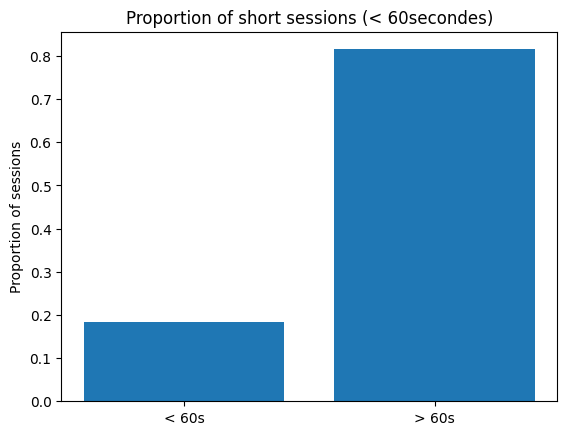

In [90]:
df["short_session"] = df["sessionuptime_duration"] < 60
short_rate_mean = df["short_session"].mean()

plt.bar(["< 60s", "> 60s"], [short_rate_mean, 1 - short_rate_mean])
plt.ylabel("Proportion of sessions")
plt.title("Proportion of short sessions (< 60secondes)")
plt.show()

Une part importante des sessions a une durée inférieur à 60 secondes ce qui peut correspondre à des échecs de connexion, des problèmes techniques, des abandons rapides de joueurs
>A significant proportion of sessions last less than 60 seconds, which can be attributed to connection failures, technical issues, or players quickly leaving the site.

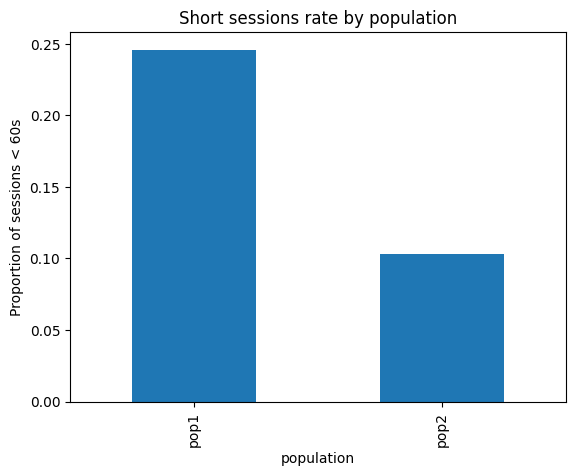

In [91]:
short_by_pop = (df.groupby("population")["short_session"].mean().sort_values(ascending=False))

short_by_pop.plot(kind="bar")
plt.ylabel("Proportion of sessions < 60s")
plt.title("Short sessions rate by population")
plt.show()

Le taux de sessions très courtes est nettement différent entre les populations, la pop1 présente une proportion bien plus élevé de sessions de moins de 60 secondes.
>The rate of very short sessions is clearly different between populations, with pop1 showing a much higher proportion of sessions of less than 60 seconds.

/var/folders/kl/3nc79ycx61v13jbqlw61nnfw0000gn/T/ipykernel_13334/1185601942.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=populations, showfliers=False)


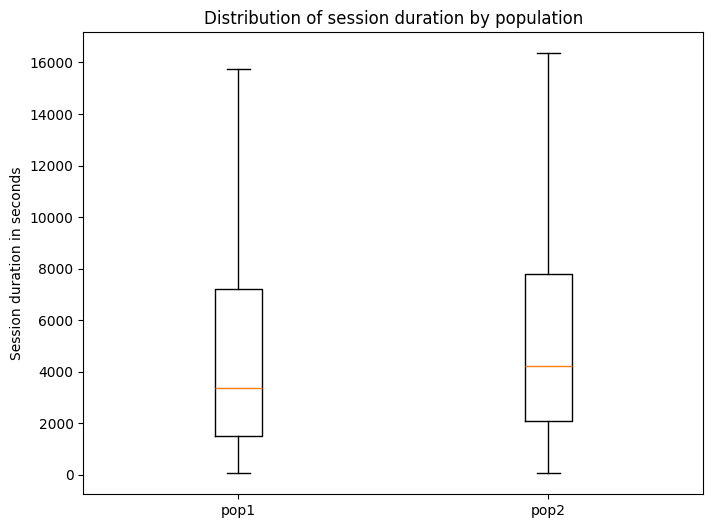

In [97]:
df_session = df[df["sessionuptime_duration"] > 60].copy()
populations = ["pop1", "pop2"]
data = []
for pop in populations:
    durations = df_session.loc[
        df_session["population"] == pop,
        "sessionuptime_duration"
    ]
    data.append(durations)

plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=populations, showfliers=False)
plt.ylabel("Session duration in seconds")
plt.title("Distribution of session duration by population")
plt.show()


J'ai exclu les sessions courtes pour verifier la distribution de durée de session des différentes populations, et il apparait clairement que la pop2 présente une durée médiane plus élevée ainsi qu’une dispersion plus importante
>I excluded short sessions to verify the session duration distribution of the different populations, and it clearly appears that pop2 has a higher median duration as well as a greater dispersion.